# 1. Explaratory Data Analysis

In [85]:
# Import libraries for data analysis
import fastf1 as f1
import pandas as pd
import seaborn as sns
import scipy.stats as stats

## 1-1. Observe difference in race times for the same track between different years

We will compare how the race times for the same racetrack for the same driver across different years to determine how to define our dataset. We have chosen 2022 and 2023, as 2022 was the last time the FIA introduced a major rule change. 
We have chosen Verstappen and Perez as their cars have shown consistent results throughout the two years (2022 and 2023).

In [45]:
race_hist

,Driver,Year,Location,Laptime
0,VER,2022,Bahrain,0 days 00:01:40.236000
1,VER,2022,Bahrain,0 days 00:01:37.880000
2,VER,2022,Bahrain,0 days 00:01:38.357000
3,VER,2022,Bahrain,0 days 00:01:38.566000
4,VER,2022,Bahrain,0 days 00:01:38.877000
...,...,...,...,...
6761,PER,2022,Yas Island,0 days 00:01:29.152000
6762,PER,2022,Yas Island,0 days 00:01:29.205000
6763,PER,2022,Yas Island,0 days 00:01:29.446000
6764,PER,2022,Yas Island,0 days 00:01:29.573000


In [40]:
temp

,Driver,Year,Location,Laptime
0,PER,2023,Abu Dhabi,0 days 00:01:37.745000
1,PER,2023,Abu Dhabi,0 days 00:01:31.672000
2,PER,2023,Abu Dhabi,0 days 00:01:30.469000
3,PER,2023,Abu Dhabi,0 days 00:01:30.759000
4,PER,2023,Abu Dhabi,0 days 00:01:30.797000
5,PER,2023,Abu Dhabi,0 days 00:01:30.682000
6,PER,2023,Abu Dhabi,0 days 00:01:30.818000
7,PER,2023,Abu Dhabi,0 days 00:01:30.993000
8,PER,2023,Abu Dhabi,0 days 00:01:31.287000
9,PER,2023,Abu Dhabi,0 days 00:01:31.214000


In [46]:
# Create a dataset and collect all the laptimes for Verstappen and Perez
race_hist = pd.DataFrame()
Years = [2022, 2023]
record = []
for year in Years:
    Events = f1.get_event_schedule(year)
    for _, Event in Events[Events['Session5'] == 'Race'].iterrows():
        session = f1.core.Session(Event, session_name = 'Race', f1_api_support  = True)
        session.load(laps = True, telemetry = True, weather = True, messages = True)

        drivers = ['VER', 'PER']

        for driver in drivers:
            sesh_l = session.laps
            sesh_driver = sesh_l.pick_driver(driver).reset_index()
            sesh_driver = sesh_driver[sesh_driver['LapTime'].isna() == False]
            sesh_driver = sesh_driver[sesh_driver[['PitOutTime', 'PitInTime']].isna().all(axis=1)]

            temp = pd.DataFrame(columns = ['Driver', 'Year', 'Location', 'Laptime'])
            temp['Laptime'] = sesh_driver['LapTime']
            temp['Driver'] = sesh_driver['Driver']
            temp['Year'] = year
            temp['Location'] = Event['Location']
            record.append(len(temp))

            race_hist = pd.concat([race_hist, temp], axis = 0, ignore_index = True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2022/1/results.json failed; using cached response
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests_cache/session.py", line 285, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests_cache/session.py", line 253, in _send_and_cache
    response = super().send(request, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fastf1/req.py", line 125, in send
    lim.limit()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fastf1/req.py", line 102, in limit
    raise RateLimitExceede

In [63]:
# Convert timedelta objects to total seconds 
for i in range(len(race_hist['Laptime'])):
    race_hist['Laptime'].loc[i] = race_hist['Laptime'].loc[i].total_seconds()

/var/folders/6w/mwtlgysd2t52bngvy31h_d3m0000gn/T/ipykernel_1897/134486317.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  race_hist['Laptime'].loc[i] = race_hist['Laptime'].loc[i].total_seconds()
/var/folders/6w/mwtlgysd2t52bngvy31h_d3m0

In [102]:
race_hist.to_csv('./lap_records_22_23.csv')

In [65]:
# Isolate the datasets by year
race_22 = race_hist[race_hist['Year'] == 2022]
race_23 = race_hist[race_hist['Year'] == 2023]

# Get all the racetracks for each year
locs_22 = race_22.Location.unique()
locs_23 = race_23.Location.unique()

# Obtain the racetracks used in both years
common_tracks = set(locs_22) - (set(locs_22) - set(locs_23))
common_tracks = list(common_tracks)

In [79]:
# Eliminate instances on racetracks where the drivers DNF
Years = [2022, 2023]
drivers = ['VER', 'PER']
ver_dnf = []
per_dnf = []

for yr in Years:
    for locs in common_tracks:
        session = f1.get_session(yr, locs, 'r')
        session.load(laps = True)
        sesh_r = session.results
        VER_res = sesh_r[sesh_r['Abbreviation'] == 'VER']
        PER_res = sesh_r[sesh_r['Abbreviation'] == 'PER']
        for _, r in VER_res.iterrows():
            if ('+' not in r['Status']) & ('Finished' not in r['Status']):
                ver_dnf.append(locs)
        
        for _, r in PER_res.iterrows():
            if ('+' not in r['Status']) & ('Finished' not in r['Status']):
                per_dnf.append(locs)
        

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2022/14/results.json failed; using cached response
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests_cache/session.py", line 285, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests_cache/session.py", line 253, in _send_and_cache
    response = super().send(request, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fastf1/req.py", line 125, in send
    lim.limit()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fastf1/req.py", line 102, in limit
    raise RateLimitExceed

In [70]:
race_hist.columns

Index(['Driver', 'Year', 'Location', 'Laptime'], dtype='object')

In [81]:
ver_dnf

['Melbourne', 'Sakhir']

In [82]:
# Conduct normality test on the races using Kolomogorav Smirnov test
def norm_test(common_tracks, dnf, driver):
    tracks = list(set(common_tracks) - set(dnf))
    norm = []
    not_norm = []
    hist = race_hist[race_hist['Driver'] == driver]
    for loc in tracks:
        for year in [2022, 2023]:
            dat = hist[(hist['Location'] == loc) &
                       (hist['Year'] == year)]['Laptime'].astype(int)
            mean_val = dat.mean()
            sd_val = dat.std()
            if stats.kstest(rvs = dat, cdf = 'norm', args = (mean_val, sd_val)).pvalue < 0.05:
                        ks_score = stats.kstest(rvs = dat, cdf = 'norm', args = (mean_val, sd_val)).statistic
                        not_norm.append((driver, loc, year, ks_score))
            else:
                norm.append((driver, loc, year))      
    return (len(norm), len(not_norm))

In [83]:
norm_test(common_tracks, ver_dnf, 'VER')

(3, 33)

In [84]:
norm_test(common_tracks, per_dnf, 'PER')

(2, 28)

The Kolomogorov-Smirnov test shows that the datasets are not normally distributed. This can be easily observed by plotting an instance of the dataset as shown below. We will plot the distribution of the time it took of Verstappen to complete the race in Bahrain in 2022.

In [87]:
race_hist

,Driver,Year,Location,Laptime
0,VER,2022,Sakhir,100.236
1,VER,2022,Sakhir,97.88
2,VER,2022,Sakhir,98.357
3,VER,2022,Sakhir,98.566
4,VER,2022,Sakhir,98.877
...,...,...,...,...
4541,PER,2023,Yas Island,88.024
4542,PER,2023,Yas Island,88.187
4543,PER,2023,Yas Island,87.896
4544,PER,2023,Yas Island,87.991


In [93]:
len(common_tracks)

20

In [103]:
ver_hist_22 = race_hist[(race_hist['Driver'] == 'VER') & 
                        (race_hist['Year'] == 2022) & 
                        (race_hist['Location'].isin(ver_tracks))]

ver_hist_22.to_csv('./ver_22.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

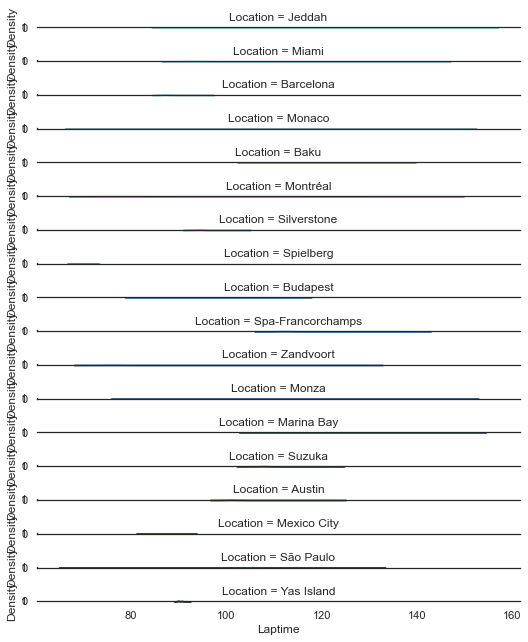

In [99]:
ver_tracks = list(set(common_tracks) - set(ver_dnf))

ver_hist_22 = race_hist[(race_hist['Driver'] == 'VER') & 
                        (race_hist['Year'] == 2022) & 
                        (race_hist['Location'].isin(ver_tracks))]

    

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(20, rot=-.25, light=.7)
g = sns.FacetGrid(ver_hist_22, row="Location", hue="Location", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Laptime",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Laptime", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Laptime")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [ ]:
sns

In [92]:
sns.boxplot(x = common_tracks, y = race_hist['Laptime'], data = race_hist[(race_hist['Driver'] == 'VER')])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


KeyError: 'Spa-Francorchamps'

In [ ]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'VER')])

<AxesSubplot:>

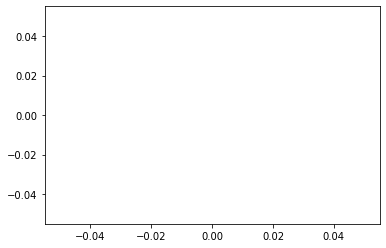

In [86]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Bahrain') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int))

In [ ]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Bahrain') & 
        (race_hist['Year'] == 2023)]['Laptime'].astype(int))

In [ ]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'PER') & 
        (race_hist['Location'] == 'Bahrain') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int))

In [ ]:
sns.histplot(data = race_hist[(race_hist['Driver'] == 'PER') & 
        (race_hist['Location'] == 'Bahrain') & 
        (race_hist['Year'] == 2023)]['Laptime'].astype(int))

It is visibally obvious that the dataset is highly skewed with outliers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Visualize how the time it took to complete a lap differs 
laptime = race_hist[(race_hist['Driver'] == 'VER') & 
        (race_hist['Location'] == 'Bahrain') & 
        (race_hist['Year'] == 2022)]['Laptime'].astype(int).to_numpy()
x = np.arange(len(laptime))
plt.plot(x, list(laptime))

Potting the lap times by the lap number visually shows how the laps times are highly skewed.

Since the dataset is clearly not normally distributed we will be using a Kruskal-Wallis test to see if the median values across two years in the same race between the same players are equal.

In [ ]:
null_hypo = []
alt_hypo = []
for drv in drivers:
    for loc in locations:
        dat = race_hist[(race_hist['Driver'] == drv )&
                      (race_hist['Location'] == loc )]
        if (dat[dat.Year == 2022].empty == False) & (dat[dat.Year == 2023].empty == False):
            dat_2022 = dat[dat['Year'] == 2022]['Laptime'].astype(int)
            dat_2023 = dat[dat['Year'] == 2023]['Laptime'].astype(int)
            if stats.kruskal(dat_2022, dat_2023).pvalue < 0.05:
                alt_hypo.append((drv, loc))
            else:
                null_hypo.append((drv, loc))
len(alt_hypo) > len(null_hypo)
alt_hypo

The results show that for the vast majority of cases the two distributions are not equal.

# Conclusion

The Kruskal Wallis test confirms that the two distributions for a driver in the same racetrack across the two years are not equal. In fact they seem to be faster on average. 

Additionally, in 2022 due to the changes in regulations the Mercedes team suffered heavily with porpoising. This lead to the team underscording compared to usual. This suggests that combining the results from 2022 and 2023 to create a large dataset would not be appropriate. 
Moreover, teams regularly repair and change vehicles between races due to DNFs or performance issues etc. Therefore fitting a model using data where a single time point is defined as a lap seems inappropriate. Instead, our model should use telemetry data to predict what would happen within a single lap. 

The data creation file uses telemetry data to predict the changes in positions within a race. The reults would then be used assist in determining whether a tyre change would be advisory or not. 

In [46]:
race = f1.get_session(2023, "Azerbaijan", 'R')
race.load()

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']


In [47]:
driver_laps = race.laps.pick_driver("ALO").pick_quicklaps().reset_index()

In [48]:
driver_laps

,index,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,154,0 days 01:06:44.092000,ALO,14,0 days 00:01:48.064000,2.0,1.0,NaT,NaT,0 days 00:00:38.837000,...,False,Aston Martin,0 days 01:04:56.028000,2023-04-30 11:05:57.498,1,6.0,False,,False,True
1,155,0 days 01:08:31.874000,ALO,14,0 days 00:01:47.782000,3.0,1.0,NaT,NaT,0 days 00:00:38.471000,...,False,Aston Martin,0 days 01:06:44.092000,2023-04-30 11:07:45.562,1,6.0,False,,False,True
2,156,0 days 01:10:19.786000,ALO,14,0 days 00:01:47.912000,4.0,1.0,NaT,NaT,0 days 00:00:38.499000,...,False,Aston Martin,0 days 01:08:31.874000,2023-04-30 11:09:33.344,1,6.0,False,,False,True
3,157,0 days 01:12:07.685000,ALO,14,0 days 00:01:47.899000,5.0,1.0,NaT,NaT,0 days 00:00:38.434000,...,False,Aston Martin,0 days 01:10:19.786000,2023-04-30 11:11:21.256,1,6.0,False,,False,True
4,158,0 days 01:13:56.052000,ALO,14,0 days 00:01:48.367000,6.0,1.0,NaT,NaT,0 days 00:00:38.499000,...,False,Aston Martin,0 days 01:12:07.685000,2023-04-30 11:13:09.155,1,6.0,False,,False,True
5,159,0 days 01:15:44.007000,ALO,14,0 days 00:01:47.955000,7.0,1.0,NaT,NaT,0 days 00:00:38.502000,...,False,Aston Martin,0 days 01:13:56.052000,2023-04-30 11:14:57.522,1,6.0,False,,False,True
6,160,0 days 01:17:31.069000,ALO,14,0 days 00:01:47.062000,8.0,1.0,NaT,NaT,0 days 00:00:38.235000,...,False,Aston Martin,0 days 01:15:44.007000,2023-04-30 11:16:45.477,1,6.0,False,,False,True
7,161,0 days 01:19:19.899000,ALO,14,0 days 00:01:48.830000,9.0,1.0,NaT,NaT,0 days 00:00:39.229000,...,False,Aston Martin,0 days 01:17:31.069000,2023-04-30 11:18:32.539,1,5.0,False,,False,True
8,162,0 days 01:21:07.315000,ALO,14,0 days 00:01:47.416000,10.0,1.0,NaT,NaT,0 days 00:00:38.237000,...,False,Aston Martin,0 days 01:19:19.899000,2023-04-30 11:20:21.369,12,5.0,False,,False,True
9,166,0 days 01:30:52.442000,ALO,14,0 days 00:01:48.907000,14.0,2.0,NaT,NaT,0 days 00:00:39.865000,...,False,Aston Martin,0 days 01:29:03.535000,2023-04-30 11:30:05.005,1,4.0,False,,False,True
